Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders

train_filename = 'notMNIST_large.tar.gz'
test_filename = 'notMNIST_small.tar.gz'

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [13]:
#display randomly 2 images from each folder
#let us get the folder for each of the image
import random
for folder in train_folders:
    print("displaying randomly 2 images from folder ",str(folder))
    #how many images it has?
    imagesFiles = os.listdir(folder)
    #get randomly 2 filenames
    randIndices = random.sample(range(0, len(imagesFiles)), 10)
    for i in randIndices:
        print("displaying image,",i, "out of:",len(imagesFiles))
        display(Image(filename = os.path.join(folder,imagesFiles[i])))  

displaying randomly 2 images from folder  notMNIST_large\A
displaying image, 43803 out of: 52912


displaying image, 29909 out of: 52912


displaying image, 34487 out of: 52912


displaying image, 22252 out of: 52912


displaying image, 28525 out of: 52912


displaying image, 28019 out of: 52912


displaying image, 42851 out of: 52912


displaying image, 31581 out of: 52912


displaying image, 7844 out of: 52912


displaying image, 47300 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\B
displaying image, 31100 out of: 52912


displaying image, 47089 out of: 52912


displaying image, 29859 out of: 52912


displaying image, 48911 out of: 52912


displaying image, 26417 out of: 52912


displaying image, 5825 out of: 52912


displaying image, 49322 out of: 52912


displaying image, 36301 out of: 52912


displaying image, 36032 out of: 52912


displaying image, 30003 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\C
displaying image, 22750 out of: 52912


displaying image, 38725 out of: 52912


displaying image, 4582 out of: 52912


displaying image, 18656 out of: 52912


displaying image, 15227 out of: 52912


displaying image, 44296 out of: 52912


displaying image, 12662 out of: 52912


displaying image, 16874 out of: 52912


displaying image, 35561 out of: 52912


displaying image, 32431 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\D
displaying image, 6030 out of: 52912


displaying image, 14838 out of: 52912


displaying image, 43177 out of: 52912


displaying image, 20686 out of: 52912


displaying image, 21031 out of: 52912


displaying image, 42638 out of: 52912


displaying image, 1454 out of: 52912


displaying image, 5558 out of: 52912


displaying image, 32742 out of: 52912


displaying image, 34987 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\E
displaying image, 34917 out of: 52912


displaying image, 28645 out of: 52912


displaying image, 52056 out of: 52912


displaying image, 11983 out of: 52912


displaying image, 35367 out of: 52912


displaying image, 6759 out of: 52912


displaying image, 14314 out of: 52912


displaying image, 44378 out of: 52912


displaying image, 32099 out of: 52912


displaying image, 46041 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\F
displaying image, 13929 out of: 52912


displaying image, 22628 out of: 52912


displaying image, 15046 out of: 52912


displaying image, 32253 out of: 52912


displaying image, 29396 out of: 52912


displaying image, 4046 out of: 52912


displaying image, 18590 out of: 52912


displaying image, 27379 out of: 52912


displaying image, 49209 out of: 52912


displaying image, 52683 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\G
displaying image, 24451 out of: 52912


displaying image, 14864 out of: 52912


displaying image, 34666 out of: 52912


displaying image, 48745 out of: 52912


displaying image, 29226 out of: 52912


displaying image, 29491 out of: 52912


displaying image, 24443 out of: 52912


displaying image, 1326 out of: 52912


displaying image, 42097 out of: 52912


displaying image, 38618 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\H
displaying image, 45942 out of: 52912


displaying image, 34514 out of: 52912


displaying image, 11997 out of: 52912


displaying image, 5019 out of: 52912


displaying image, 743 out of: 52912


displaying image, 22288 out of: 52912


displaying image, 17282 out of: 52912


displaying image, 39348 out of: 52912


displaying image, 22985 out of: 52912


displaying image, 50042 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\I
displaying image, 2058 out of: 52912


displaying image, 5344 out of: 52912


displaying image, 384 out of: 52912


displaying image, 52554 out of: 52912


displaying image, 25320 out of: 52912


displaying image, 47319 out of: 52912


displaying image, 4445 out of: 52912


displaying image, 10617 out of: 52912


displaying image, 19936 out of: 52912


displaying image, 50335 out of: 52912


displaying randomly 2 images from folder  notMNIST_large\J
displaying image, 32243 out of: 52911


displaying image, 23183 out of: 52911


displaying image, 38793 out of: 52911


displaying image, 32809 out of: 52911


displaying image, 42291 out of: 52911


displaying image, 21429 out of: 52911


displaying image, 7269 out of: 52911


displaying image, 38316 out of: 52911


displaying image, 9681 out of: 52911


displaying image, 42928 out of: 52911


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [14]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

reading pickle file  notMNIST_large\A.pickle
displaying image, 7631 out of: 52909


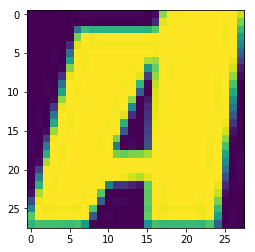

displaying image, 19148 out of: 52909


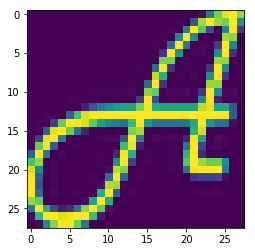

displaying image, 37586 out of: 52909


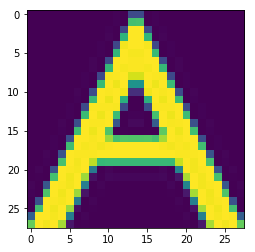

displaying image, 8589 out of: 52909


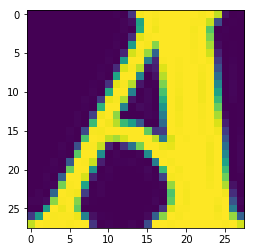

displaying image, 8311 out of: 52909


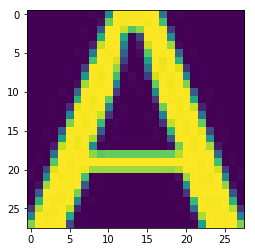

displaying image, 31399 out of: 52909


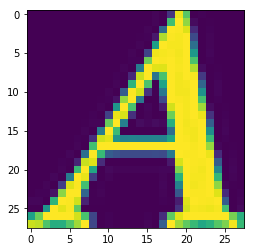

displaying image, 11835 out of: 52909


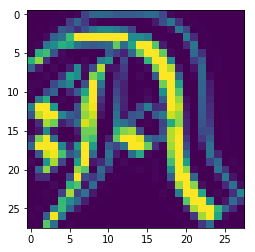

displaying image, 28483 out of: 52909


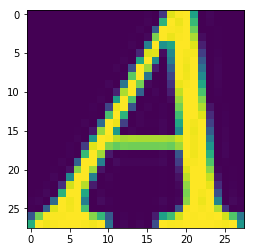

displaying image, 12033 out of: 52909


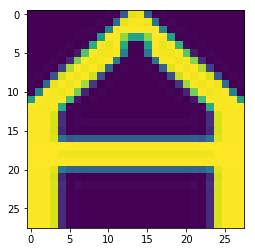

displaying image, 39690 out of: 52909


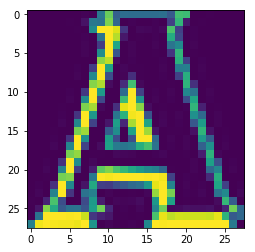

reading pickle file  notMNIST_large\B.pickle
displaying image, 34939 out of: 52911


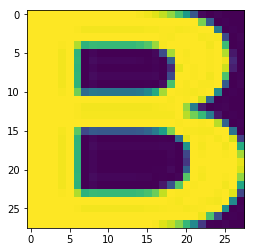

displaying image, 3024 out of: 52911


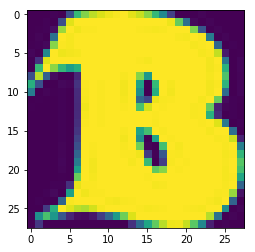

displaying image, 24260 out of: 52911


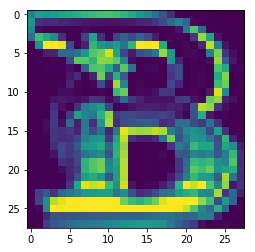

displaying image, 13537 out of: 52911


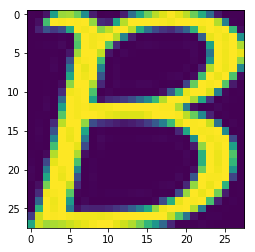

displaying image, 43359 out of: 52911


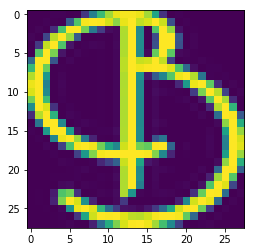

displaying image, 46814 out of: 52911


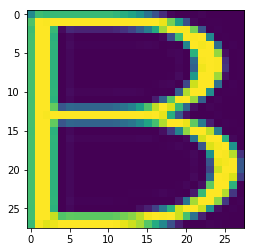

displaying image, 11207 out of: 52911


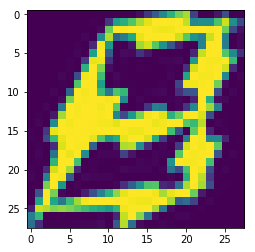

displaying image, 1793 out of: 52911


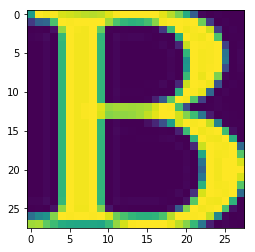

displaying image, 6881 out of: 52911


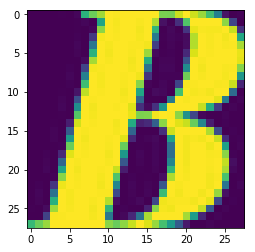

displaying image, 33488 out of: 52911


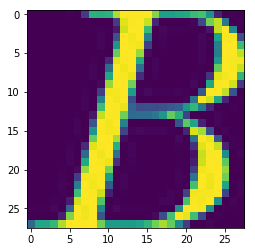

reading pickle file  notMNIST_large\C.pickle
displaying image, 23624 out of: 52912


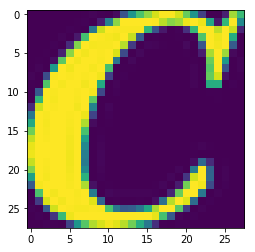

displaying image, 49081 out of: 52912


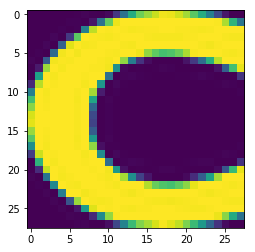

displaying image, 35457 out of: 52912


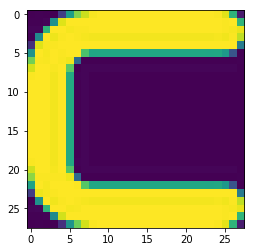

displaying image, 1479 out of: 52912


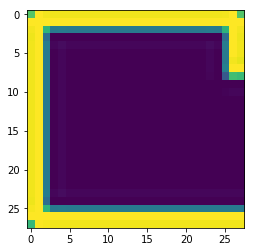

displaying image, 45946 out of: 52912


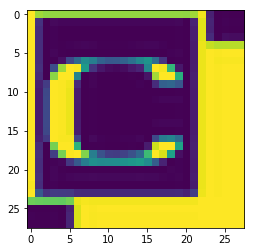

displaying image, 45926 out of: 52912


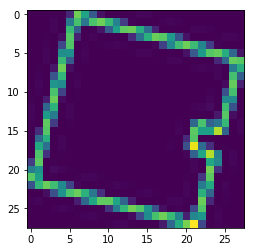

displaying image, 13962 out of: 52912


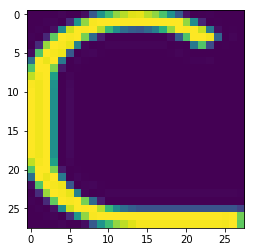

displaying image, 11475 out of: 52912


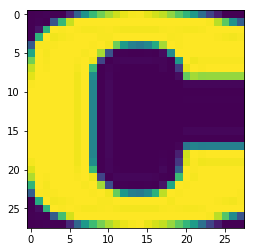

displaying image, 26868 out of: 52912


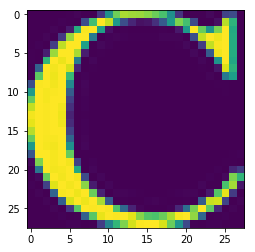

displaying image, 27077 out of: 52912


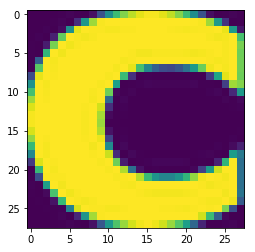

reading pickle file  notMNIST_large\D.pickle
displaying image, 35262 out of: 52911


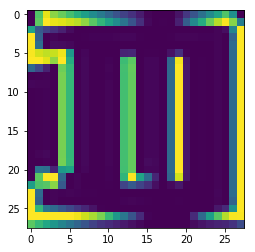

displaying image, 2122 out of: 52911


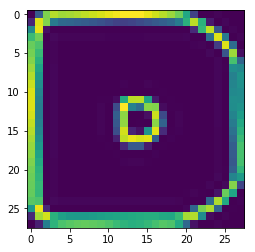

displaying image, 10275 out of: 52911


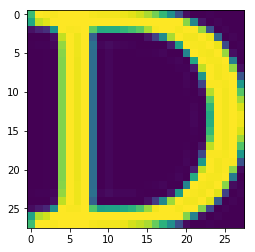

displaying image, 44688 out of: 52911


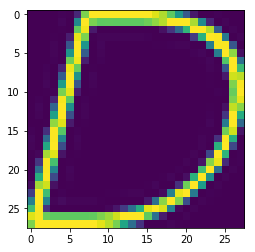

displaying image, 13319 out of: 52911


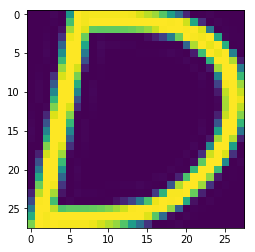

displaying image, 22074 out of: 52911


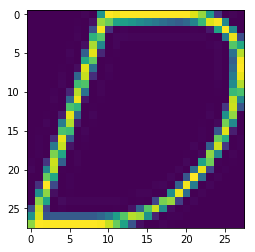

displaying image, 1988 out of: 52911


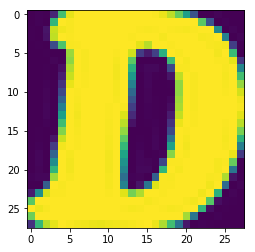

displaying image, 44185 out of: 52911


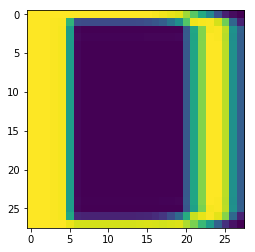

displaying image, 30136 out of: 52911


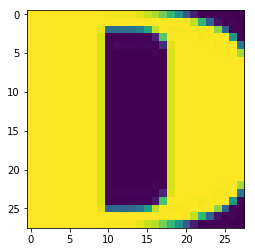

displaying image, 40931 out of: 52911


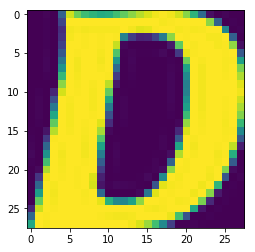

reading pickle file  notMNIST_large\E.pickle
displaying image, 52773 out of: 52912


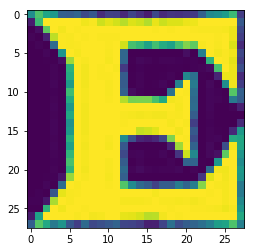

displaying image, 43600 out of: 52912


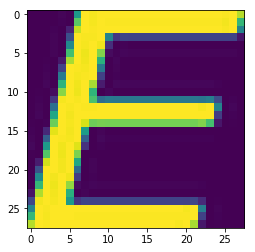

displaying image, 31119 out of: 52912


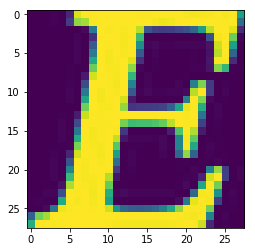

displaying image, 46934 out of: 52912


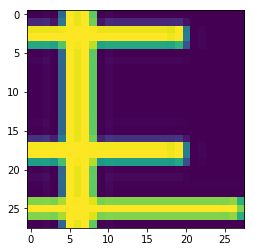

displaying image, 1978 out of: 52912


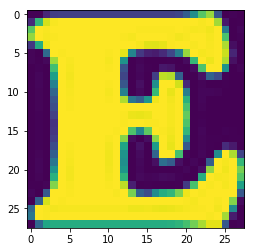

displaying image, 9635 out of: 52912


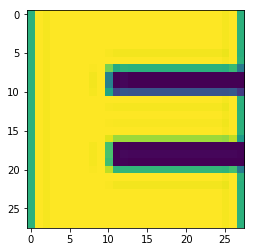

displaying image, 6605 out of: 52912


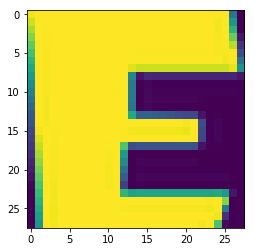

displaying image, 39962 out of: 52912


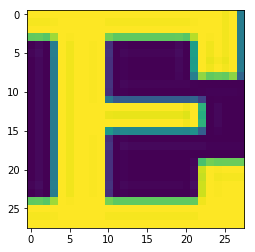

displaying image, 15248 out of: 52912


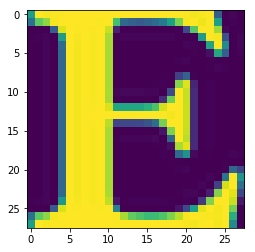

displaying image, 24125 out of: 52912


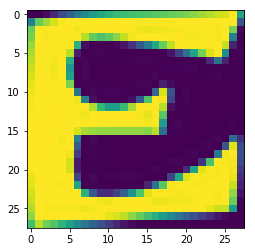

reading pickle file  notMNIST_large\F.pickle
displaying image, 6635 out of: 52912


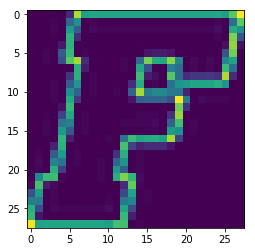

displaying image, 32890 out of: 52912


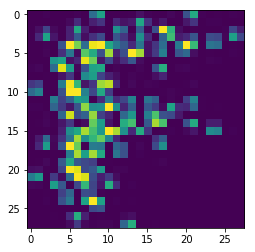

displaying image, 10930 out of: 52912


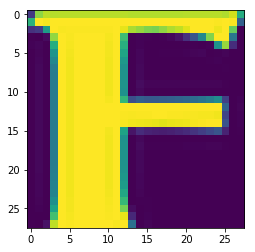

displaying image, 5830 out of: 52912


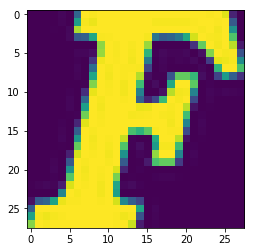

displaying image, 48450 out of: 52912


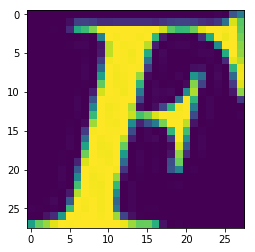

displaying image, 15836 out of: 52912


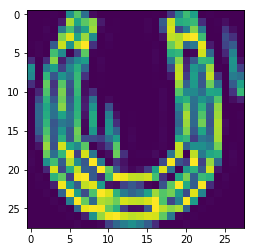

displaying image, 26377 out of: 52912


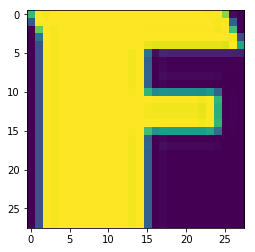

displaying image, 1327 out of: 52912


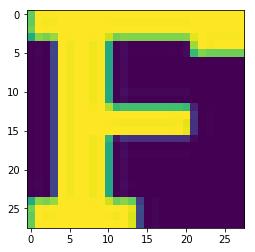

displaying image, 49290 out of: 52912


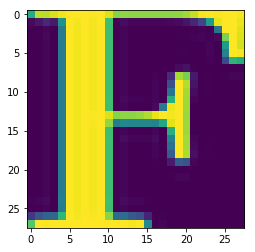

displaying image, 49015 out of: 52912


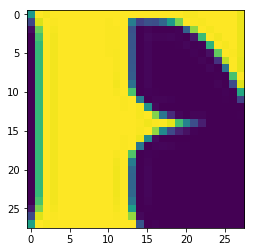

reading pickle file  notMNIST_large\G.pickle
displaying image, 13155 out of: 52912


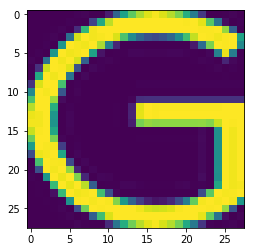

displaying image, 1330 out of: 52912


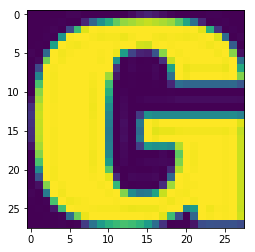

displaying image, 33442 out of: 52912


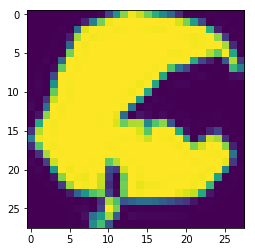

displaying image, 39079 out of: 52912


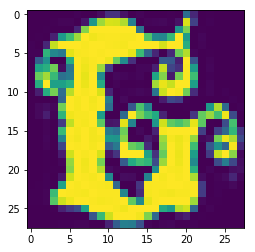

displaying image, 33962 out of: 52912


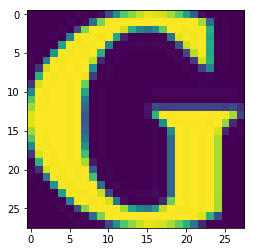

displaying image, 28926 out of: 52912


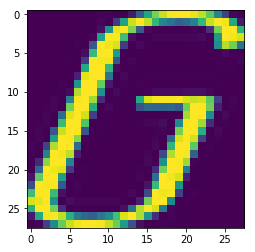

displaying image, 51884 out of: 52912


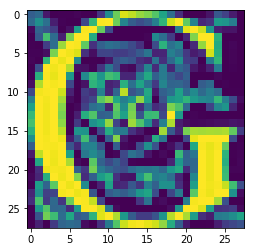

displaying image, 2523 out of: 52912


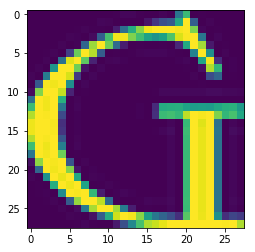

displaying image, 31910 out of: 52912


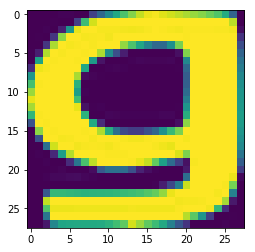

displaying image, 25850 out of: 52912


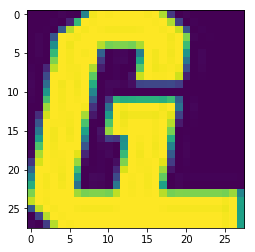

reading pickle file  notMNIST_large\H.pickle
displaying image, 7681 out of: 52912


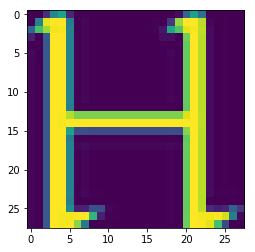

displaying image, 22409 out of: 52912


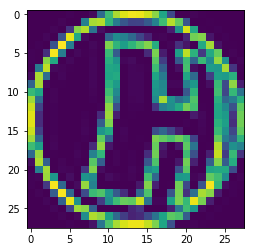

displaying image, 6233 out of: 52912


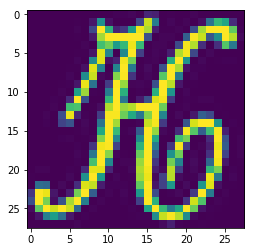

displaying image, 38841 out of: 52912


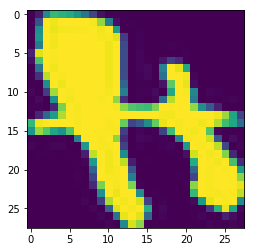

displaying image, 6998 out of: 52912


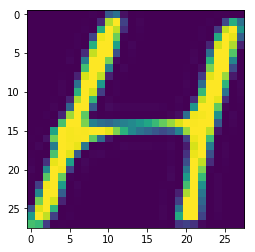

displaying image, 20844 out of: 52912


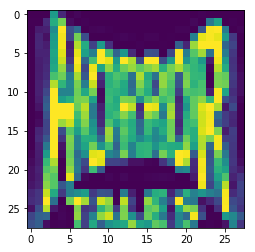

displaying image, 37972 out of: 52912


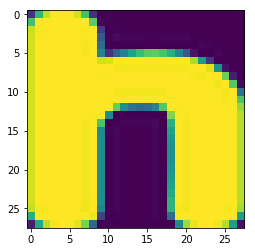

displaying image, 3070 out of: 52912


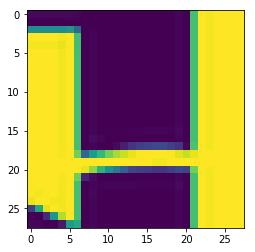

displaying image, 25419 out of: 52912


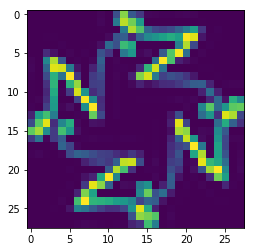

displaying image, 16958 out of: 52912


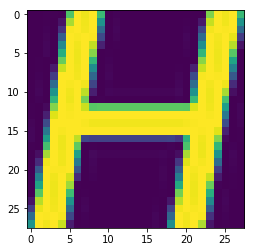

reading pickle file  notMNIST_large\I.pickle
displaying image, 37818 out of: 52912


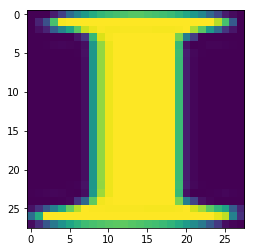

displaying image, 25861 out of: 52912


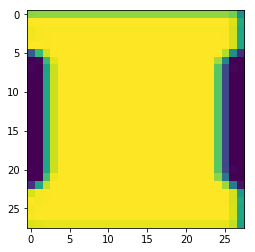

displaying image, 21098 out of: 52912


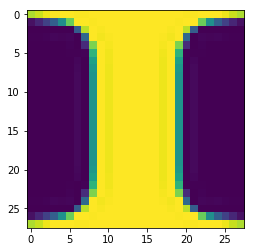

displaying image, 2295 out of: 52912


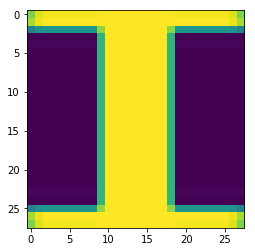

displaying image, 8463 out of: 52912


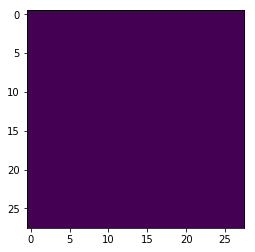

displaying image, 13389 out of: 52912


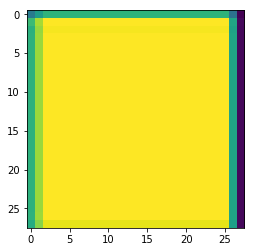

displaying image, 9097 out of: 52912


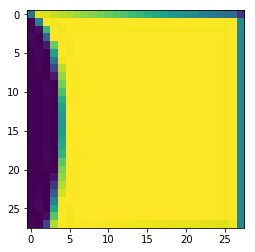

displaying image, 21733 out of: 52912


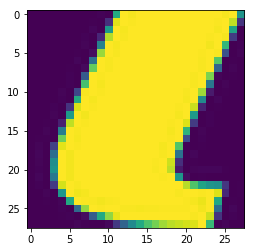

displaying image, 17994 out of: 52912


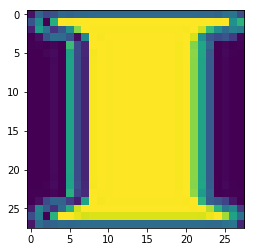

displaying image, 44652 out of: 52912


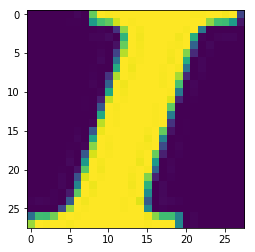

reading pickle file  notMNIST_large\J.pickle
displaying image, 32902 out of: 52911


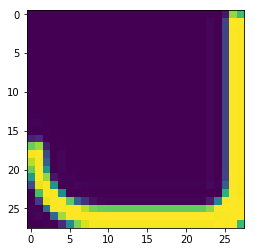

displaying image, 18276 out of: 52911


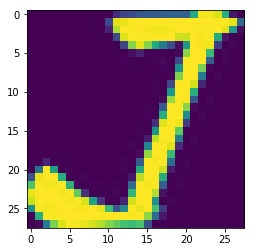

displaying image, 22568 out of: 52911


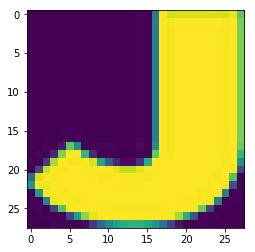

displaying image, 34007 out of: 52911


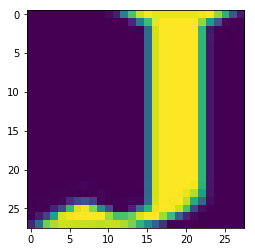

displaying image, 47673 out of: 52911


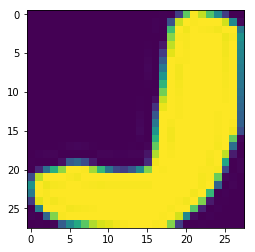

displaying image, 38020 out of: 52911


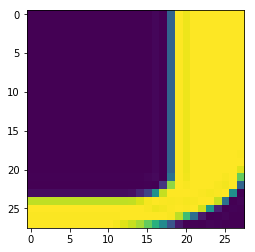

displaying image, 21613 out of: 52911


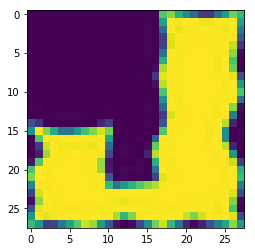

displaying image, 16149 out of: 52911


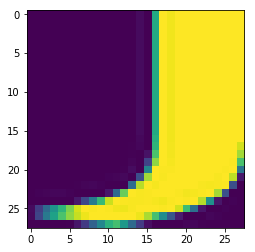

displaying image, 19772 out of: 52911


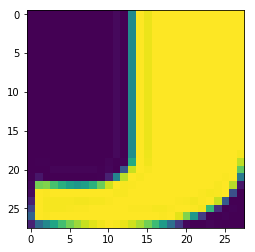

displaying image, 19282 out of: 52911


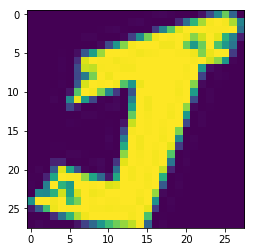

In [25]:
#lets check and make sure that the pickled images still look good
for item in train_datasets:
    print("reading pickle file ",item)
    image_data = pickle.load(open(item, "rb" ), encoding='latin1')
    #the first dimension is for the number of image and the other two dimensions give the image size
    imagesFiles = image_data.shape[0]
    #lets get randomly 10 images from this pickled data and display them
    randIndices = random.sample(range(0, imagesFiles), 10)
    for i in randIndices:
        print("displaying image,",i, "out of:",imagesFiles)
        plt.imshow(image_data[i], interpolation='nearest')
        plt.show()

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [ ]:
#lets check and make sure that the classes are roughly balanced in terms of number of images
for item in train_datasets:
    print("reading pickle file ",item)
    image_data = pickle.load(open(item, "rb" ), encoding='latin1')
    print(image_data.shape)

for item in test_datasets:
    print("reading pickle file ",item)
    image_data = pickle.load(open(item, "rb" ), encoding='latin1')
    print(image_data.shape)

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [0]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training (200000, 28, 28) (200000,)
Validation (10000, 28, 28) (10000,)
Testing (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [0]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Finally, let's save the data for later reuse:

In [0]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [0]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 718193801


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---